In [2]:
import matplotlib.pyplot as plt
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
import aosol.series.consumo as series
import aosol.series.producao as seriesprod
import aosol.series.pvgis as pvgis
import aosol.analise.analise_energia as ae
import aosol.analise.analise_financeira as af
import aosol.analise.analise_precos_energia as ape
from aosol.armazenamento import bateria
from IPython.display import display_html

# Analise de UPAC com bateria

Analise de um projecto de UPAC com dados de consumo obtidos do portal e-redes, dados de produção obtidos da plataforma PVGIS e subsequente análise dos indicadores principais do projecto: indice auto consumo (IAC), indice de auto suficiência (IAS) e indice entrega à rede (IER). É feita também uma análise financeiro do projecto.

In [3]:
# Parametros do projecto
nome_projecto = 'Covilha_6.0Kw+3Kwh'
# =====================
# Consumo
# =====================
ano_consumo = 2023
perfil = 'BTN C' # ver na document
consumo_anual = 8400 # kWh, exemplo consumo médio 200 kWh/mes
fich_perfil_eredes = r"./consumo/perfis_eredes/E-REDES_Perfil_Consumo_2023.csv"

# =====================
# Producao
# =====================
capacidade_instalada = 5.95 # em kW
ano_producao = 2023 # converter as datas de producao para este ano
# Opcoes API PVGIS
inicio_ano_pvgis = 2005
fim_ano_pvgis = 2023 # PVGIS-SARAH3 na V5.3 (2005-2023)
lat = 40.280         # Covilha
lon = -7.504
inclinacao = 45      # prioridade inverno
azimute = 0.0        # azimute = 180 + x; 0 = Sul
perdas = 14          # %
eficiencia_inversor = 0.96

# =====================
# Analise energetica
# =====================
analise_com_bateria = True  # solax triple power 3.0
capacidade_bat = 3          # kWh
soc_min = 0.1               # limite maximo descarregamento 
soc_max = 1.                # limite maximo carregamento, segundo documentacao capacidade util 2.7 kWh 0.9 DOD
eficiencia_bateria = 0.95
pot_maxima_bateria = 2.5    # kW , descarga nominal, máximo de 3 kW

# =====================
# Analise poupanca anual
# =====================
ano_tarifario = 2023
simples_kwh = 0.0 # simples
bihorario_fora_vazio_kwh = 0.1751
bihorario_vazio_kwh = 0.1001
trihorario_ponta_kwh = 0.0
trihorario_cheias_kwh = 0.0
trihorario_vazio_kwh = 0.0
# venda a rede com preco fixo
preco_venda_rede = 0.04 # 4cent/kWh
precos_energia = ape.TarifarioEnergia(simples_kwh, \
    bihorario_fora_vazio_kwh, bihorario_vazio_kwh, \
    trihorario_ponta_kwh, trihorario_cheias_kwh, trihorario_vazio_kwh, \
    preco_venda_rede)

# =====================
# Analise tempo de vida
# =====================
tempo_vida = 20 # anos
ano_0 = 2023 # ano 0 do projecto
taxa_actualizacao = 5 # em %
taxa_degradacao_sistema = 0.7 # %/ano
taxa_inflacao = 2.0 # %/ano

# Custos do projecto
# investimento_estimado = pv + instalacao + outros_custos
custo_pv = 4044        # 14 trina solar 425Wp + Solax X1-Hybrid 6.0T
custo_bat = 2000       # Solax triple power T30 3 kWh
custo_instalacao = 450
outros_custos = 800    # monitorização + contador eredes
# custo manutencao anual como percentagem do investimento
perc_custo_manutencao = 0.5 # em %
# apoio estatal (fundo ambiental)
considerar_apoio = False
perc_apoio = 85 # em % do investimento estimado
apoio_max = 2500 # em €, valor maximo pago pelo fundo

## 1. Consumo

Utilização de perfil médio da e-redes

In [4]:
perfil_eredes = series.leitura_perfis_eredes(fich_perfil_eredes, perfil)
consumo = series.ajustar_perfil_eredes_a_consumo_anual(perfil_eredes, consumo_anual, 'BTN C', 'consumo')

Consumo anual = 8400.0 kWh


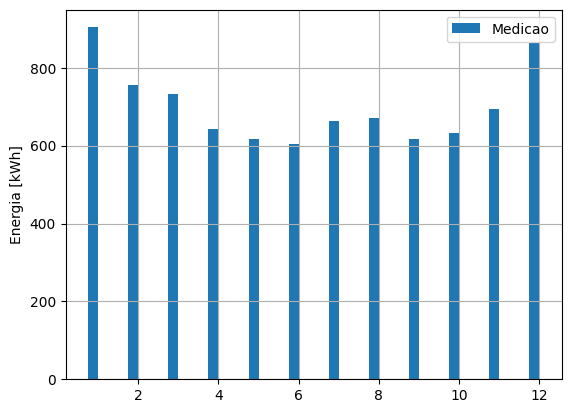

In [5]:
consumo_mensal = consumo['consumo'].resample('M').sum()

width = 0.25
plt.bar(consumo_mensal.index.month-width/2, consumo_mensal, width=width, label='Medicao')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

print("Consumo anual = {:.1f} kWh".format(consumo['consumo'].sum()))

## 2. Produção

Produção estimada através do PV GIS

In [6]:
producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=capacidade_instalada, loss=perdas)
producao = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

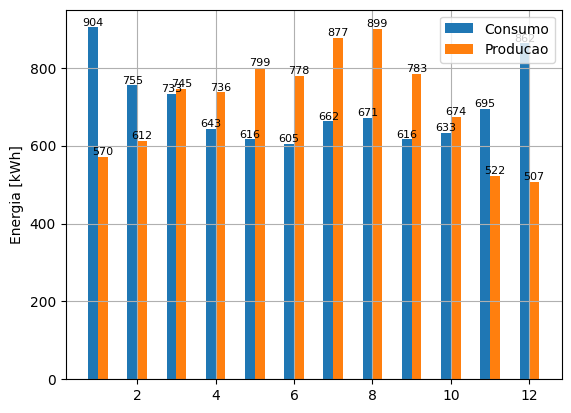

In [7]:
producao_mensal = producao.resample('M').sum()

fig, ax = plt.subplots()

width = 0.50
c = ax.bar(consumo_mensal.index.month-width/4, consumo_mensal, width=width/2, label='Consumo')
ax.bar_label(c, fmt='%d', fontsize=8)
p = ax.bar(producao_mensal.index.month+width/4, producao_mensal['autoproducao'], width=width/2, label='Producao')
ax.bar_label(p, fmt='%d', fontsize=8)
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

## 3. Análise Energético do Projecto

Considerar sistema de armazenamento com estado de carga (SOC) minimo de 20% e máximo de 80% para maximizar tempo de vida da bateria. 

In [8]:
energia_armaz = []

if analise_com_bateria:
    bat = bateria.bateria(capacidade_bat, soc_min, soc_max, eficiencia_bateria, pot_maxima=pot_maxima_bateria)

    # data frames com armazenamento
    energia_armaz = consumo['consumo'].to_frame('consumo')
    energia_armaz = energia_armaz.join(producao, how="outer")

    energia_armaz = ae.analisa_upac_com_armazenamento(energia_armaz, bat, eficiencia_inversor=eficiencia_inversor)

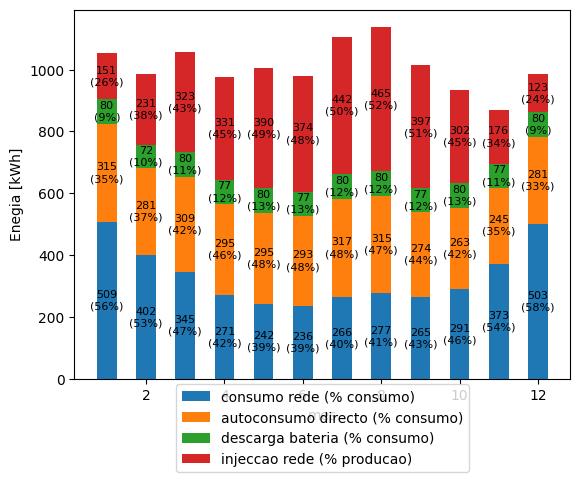

In [9]:
if analise_com_bateria:
    energia_armaz_mensal = energia_armaz.resample('M').sum()

    fig, ax = plt.subplots()

    # plot mean P50
    ae.plot_energia_mensal_bars(ax, energia_armaz_mensal, consumo_mensal, producao_mensal["autoproducao"], ["consumo_rede", "autoconsumo", "injeccao_rede", "descarga_bateria"])

In [10]:
if analise_com_bateria:
    indicadores_armaz = ae.calcula_indicadores_autoconsumo(energia_armaz, capacidade_instalada, eficiencia_inversor, bat)
    indicadores_armaz.print_html("P50")

label,P50
Potencia instalada [kW],6.0
IAS: Contributo PV [%],52.6
IAC: Indice Auto consumo [%],51.9
IER: Producao PV desperdicada [%],48.1
Energia consumida [kWh],8400.0
Energia Autoproduzida [kWh],8509.1
Energia Autoconsumida [kWh],4418.7
Energia consumida rede [kWh],3981.3
Energia injectada rede [kWh],3703.9
Perdas inversor [kWh],338.4


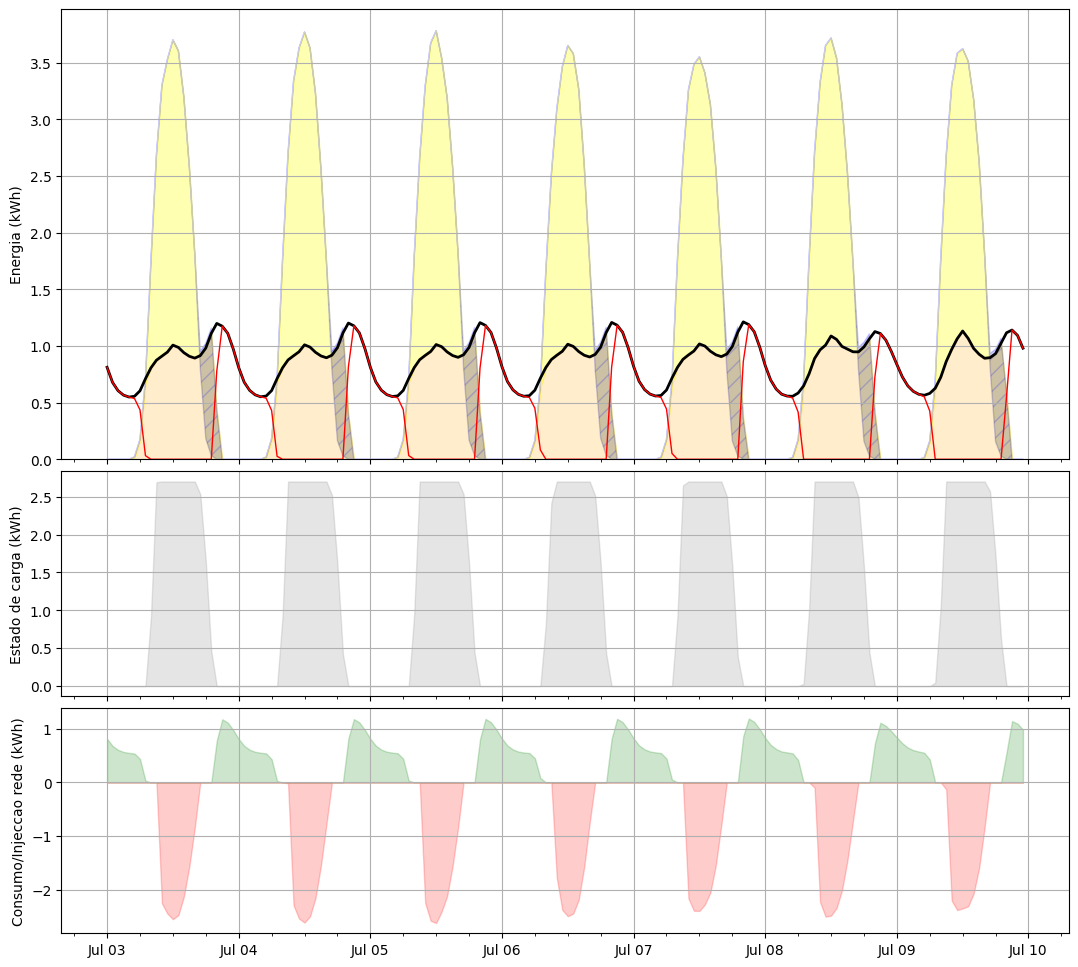

In [11]:
ae.plot_despacho_energia(energia_armaz, 27)

## 4. Análise de poupanca anual

Custos mensais por tipo tarifario.

### 4.1 UPAC sem venda à rede

In [12]:
if analise_com_bateria:
    # custos tarifario simples
    #mensal_simples = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Simples, precos_energia, False, ['consumo', 'consumo_rede'])
    #simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

    mensal_bihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Bihorario, precos_energia, False, ['consumo', 'consumo_rede'])
    bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

    #mensal_trihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Trihorario, precos_energia, False, ['consumo', 'consumo_rede'], ano_tarifario)
    #trihorario_styler = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")
    
    # display todos
    #display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_styler._repr_html_(), raw=True)
    # so simples
    #display_html(simples_styler._repr_html_(), raw=True)
    # so bihorario
    display_html(bihorario_styler._repr_html_(), raw=True)
    # so trihorario
    #display_html(trihorario_styler._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,169.87 €,84.64 €,85.23 €
Fevereiro,142.00 €,65.86 €,76.14 €
Março,138.00 €,55.17 €,82.83 €
Abril,121.39 €,42.79 €,78.60 €
Maio,116.08 €,37.73 €,78.35 €
Junho,113.74 €,36.37 €,77.37 €
Julho,124.07 €,40.77 €,83.30 €
Agosto,125.83 €,42.80 €,83.03 €
Setembro,115.96 €,42.06 €,73.90 €


### 4.2 UPAC com venda à rede

In [13]:
if analise_com_bateria:
    # simples
    #mensal_simples = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Simples, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'])
    #simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

    mensal_bihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Bihorario, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'])
    bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

    #mensal_trihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Trihorario, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'], ano_tarifario)
    #trihorario_styler = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")
    
    # display todos
    #display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_styler._repr_html_(), raw=True)
    # so simples
    #display_html(simples_styler._repr_html_(), raw=True)
    # so bihorario
    display_html(bihorario_styler._repr_html_(), raw=True)
    # so trihorario
    #display_html(trihorario_styler._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,169.87 €,84.64 €,91.25 €,6.02 €
Fevereiro,142.00 €,65.86 €,85.38 €,9.24 €
Março,138.00 €,55.17 €,95.76 €,12.93 €
Abril,121.39 €,42.79 €,91.85 €,13.25 €
Maio,116.08 €,37.73 €,93.94 €,15.59 €
Junho,113.74 €,36.37 €,92.33 €,14.96 €
Julho,124.07 €,40.77 €,100.96 €,17.66 €
Agosto,125.83 €,42.80 €,101.64 €,18.61 €
Setembro,115.96 €,42.06 €,89.80 €,15.90 €


## 5. Analise Financeira do projecto no tempo de vida

Calcular indicadores financeiros para o tempo de vida do projecto.

* VAL

* TIR

* Tempo retorno projecto

In [14]:
invest_pv = custo_pv + custo_instalacao + outros_custos
investimento_estimado = invest_pv + custo_bat

# Custo de manutencao anual
custo_manutencao = investimento_estimado * (perc_custo_manutencao / 100)

# Apoio fundo ambiental
apoio = 0
if considerar_apoio:
   apoio = min(investimento_estimado*(perc_apoio/100), apoio_max)
   investimento_estimado = investimento_estimado - apoio

print(f"Investimeto total = {investimento_estimado:.2f} €")
print(f"Custos OM = {custo_manutencao:.2f} €/ano")

Investimeto total = 7294.00 €
Custos OM = 36.47 €/ano


### 5.1 UPAC sem venda à rede

In [15]:
cols = ['consumo', 'consumo_rede']

# custos tarifario simples
#indicadores_financas_simples, cf_simples = af.analise_financeira_projecto_faturas(energia_armaz, invest_pv, custo_bat, perc_custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, False, cols, indicadores_armaz)
#simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

indicadores_financas_bihorario, _ = af.analise_financeira_projecto_faturas(energia_armaz, invest_pv, custo_bat, perc_custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, False, cols, indicadores_armaz)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

#indicadores_financas_trihorario, _ = af.analise_financeira_projecto_faturas(energia_armaz, invest_pv, custo_bat, perc_custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, False, cols, indicadores_armaz)
#trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

# display todos
#display_html(simples_style._repr_html_() + bihorario_style._repr_html_() + trihorario_style._repr_html_(), raw=True)
# so simples
#display_html(simples_style._repr_html_(), raw=True)
# so bihorario
display_html(bihorario_style._repr_html_(), raw=True)
# so trihorario
#display_html(trihorario_style._repr_html_(), raw=True)


,valores
indice,
Tempo vida util projecto [anos],20.00
Custo instalação [€],7294.00
Custo manutenção anual [€/ano],36.47
VAL [€],5089.79
TIR [%],11.93
Retorno do investimento [anos],9.90
Lcoe [€/kWh],0.08
Coe prosumidor [€/kWh],0.13


### 5.2 UPAC com venda à rede

In [16]:
cols = ['consumo', 'consumo_rede', 'injeccao_rede']

# custos tarifario simples
#indicadores_financas_simples, cf_simples = af.analise_financeira_projecto_faturas(energia_armaz, invest_pv, custo_bat, perc_custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, True, cols, indicadores_armaz)
#simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

indicadores_financas_bihorario, _ = af.analise_financeira_projecto_faturas(energia_armaz, invest_pv, custo_bat, perc_custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, True, cols, indicadores_armaz)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

#indicadores_financas_trihorario, _ = af.analise_financeira_projecto_faturas(energia_armaz, invest_pv, custo_bat, perc_custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, True, cols, indicadores_armaz)
#trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

# display todos
#display_html(simples_style._repr_html_() + bihorario_style._repr_html_() + trihorario_style._repr_html_(), raw=True)
# so simples
#display_html(simples_style._repr_html_(), raw=True)
# so bihorario
display_html(bihorario_style._repr_html_(), raw=True)
# so trihorario
#display_html(trihorario_style._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],20.00
Custo instalação [€],7294.00
Custo manutenção anual [€/ano],36.47
VAL [€],7139.77
TIR [%],14.37
Retorno do investimento [anos],8.30
Lcoe [€/kWh],0.08
Coe prosumidor [€/kWh],0.13
